Import Related Modules

In [1]:
import lime
import torch
import numpy as np
import pandas as pd
import networkx as nx
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
from lime import lime_tabular
from torch_geometric.data import Data
from sklearn.model_selection import KFold
from torch_geometric.nn import GCNConv, GATConv
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler, normalize
from torch_geometric.loader import DataLoader as GeometricDataLoader
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

Model Architecture

In [2]:
# Define Advanced GNN Model
class AdvancedGNNModel(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, dropout):
        super(AdvancedGNNModel, self).__init__()
        self.conv1 = GCNConv(num_node_features, 64)
        self.conv2 = GATConv(64, 128, heads = 4, concat = True)
        self.conv3 = GCNConv(128 * 4, 64)  # GAT outputs heads*hidden channels
        self.fc1 = torch.nn.Linear(64, 32)
        self.fc2 = torch.nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(p = dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Data Loading and Preprocessing

In [3]:
def create_custom_edge_index():
    """
    Create custom edge index based on edge list.
    """
    custom_edges = [
        (0, 10), (1, 10), (2, 5), (2, 7), (2, 10), (2, 11),
        (3, 10), (4, 10), (5, 8), (6, 10), (7, 8), (8, 9), (8, 11)
    ]
    edges = []
    for edge in custom_edges:
        i, j = edge
        edges.append([i, j])
        edges.append([j, i])  # Undirected graph
    return torch.tensor(edges, dtype=torch.long).t().contiguous()

# Create Data objects for training and testing sets
def create_graph_data(features, labels):
    edge_index = create_custom_edge_index()  # Custom edge index for all graphs
    data = Data(x = features, edge_index = edge_index, y = labels)
    return data

# Load and preprocess the data
InputData = pd.read_csv('Dataset_spine_clean.csv')
node_features = torch.tensor(InputData.iloc[13:303, 1:13].values, dtype=torch.float)
labels = torch.tensor(InputData.iloc[13:303, 14].values, dtype=torch.long)

# Standardize the features
##scaler = StandardScaler()
##node_features = torch.tensor(scaler.fit_transform(node_features), dtype=torch.float)

CROSS VALIDATION

Fold 1/5
Best parameters for fold 1: {'dropout': 0.1, 'learning_rate': 0.002, 'weight_decay': 1e-06}
Retraining the model with best parameters...
Early stopping at epoch 59


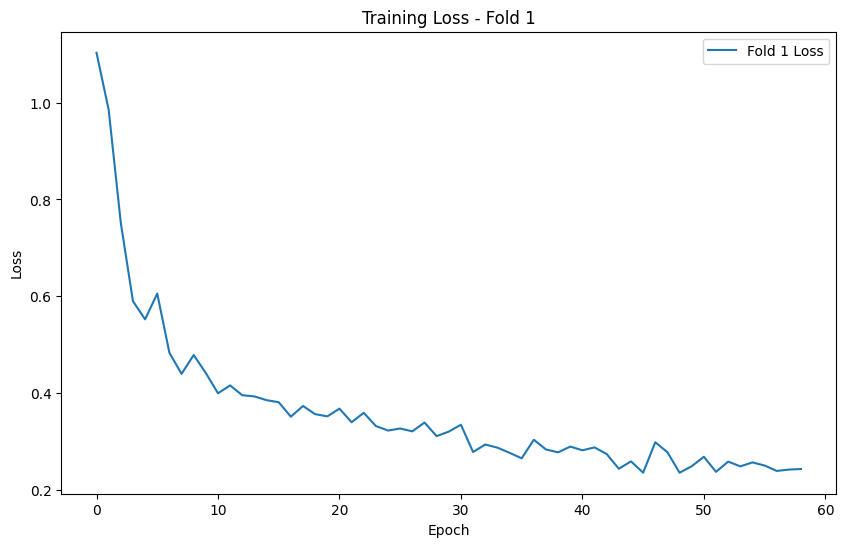

Fold 1 - Accuracy: 0.9483, Precision: 0.9634, Recall: 0.9250, F1 Score: 0.9405, ROC AUC: 0.9974


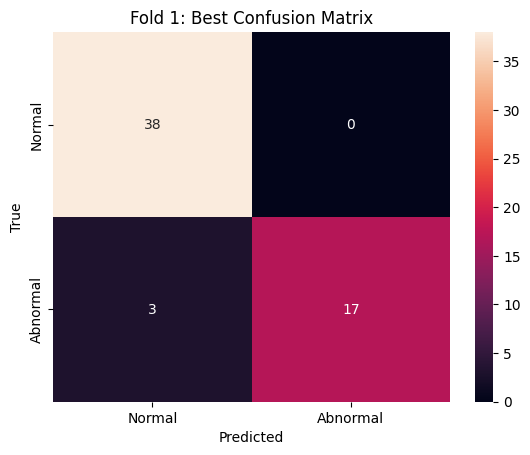

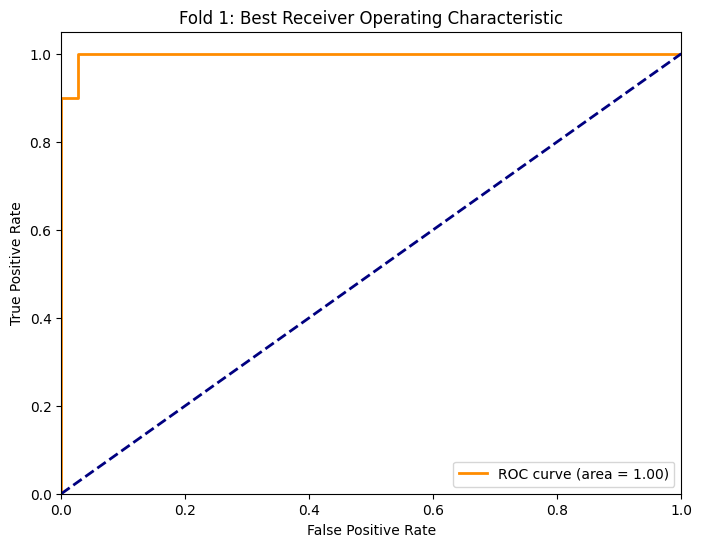

Fold 2/5
Best parameters for fold 2: {'dropout': 0.1, 'learning_rate': 0.002, 'weight_decay': 1e-06}
Retraining the model with best parameters...
Early stopping at epoch 98


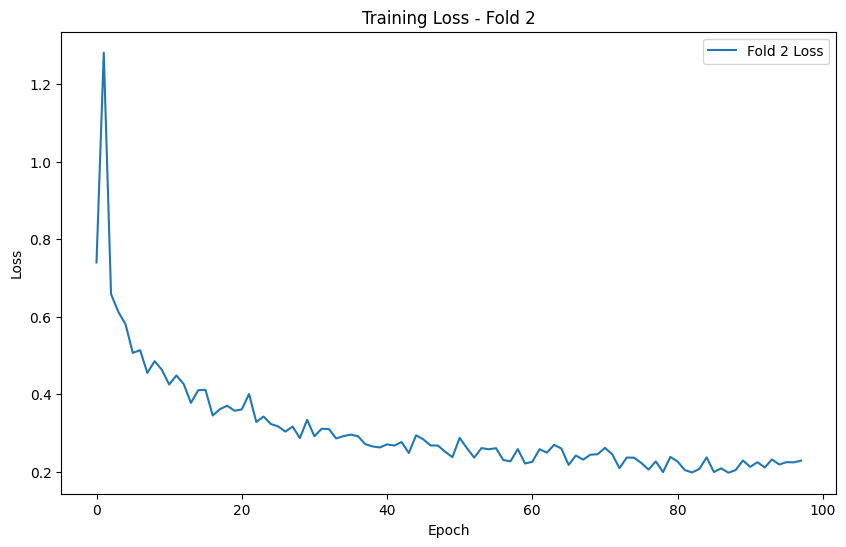

Fold 2 - Accuracy: 0.9828, Precision: 0.9881, Recall: 0.9706, F1 Score: 0.9788, ROC AUC: 0.9785


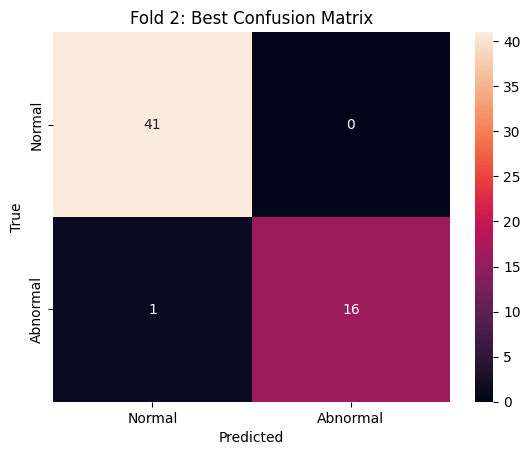

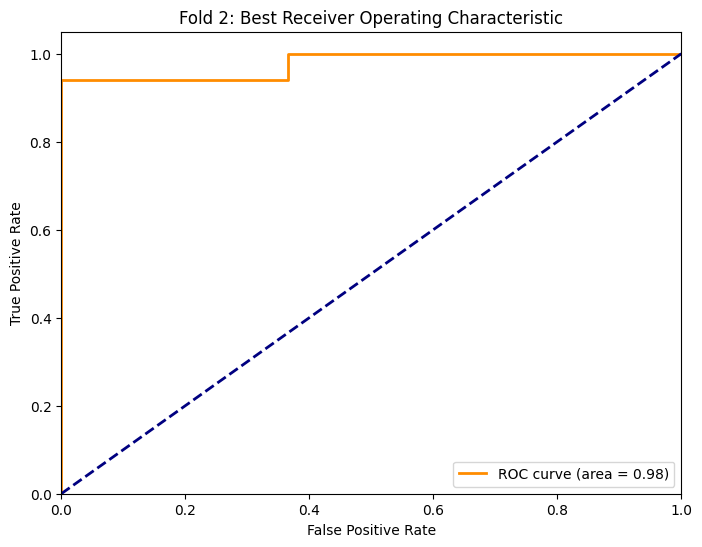

Fold 3/5
Best parameters for fold 3: {'dropout': 0.1, 'learning_rate': 0.002, 'weight_decay': 1e-05}
Retraining the model with best parameters...
Early stopping at epoch 44


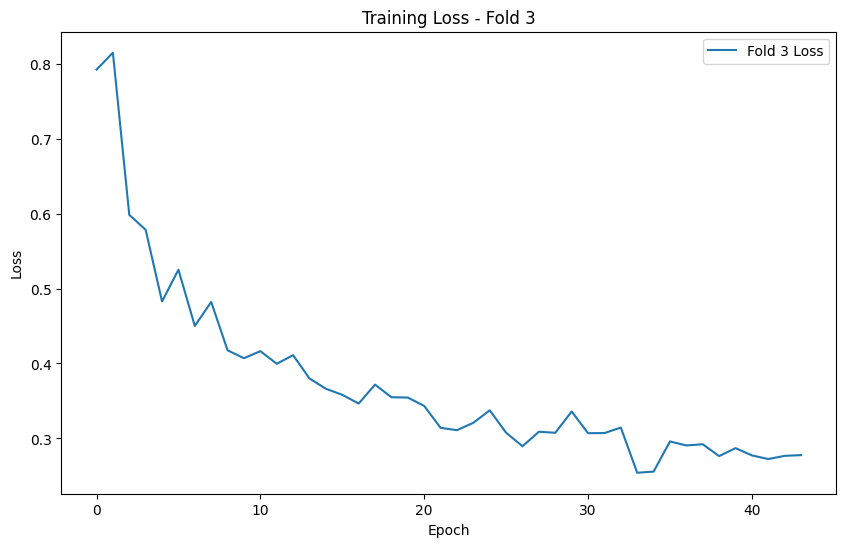

Fold 3 - Accuracy: 0.9483, Precision: 0.9659, Recall: 0.9118, F1 Score: 0.9340, ROC AUC: 1.0000


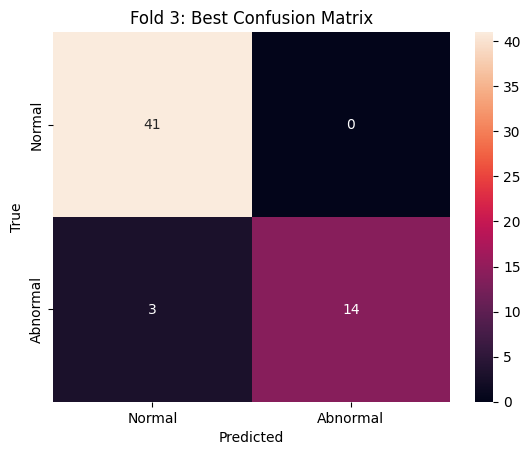

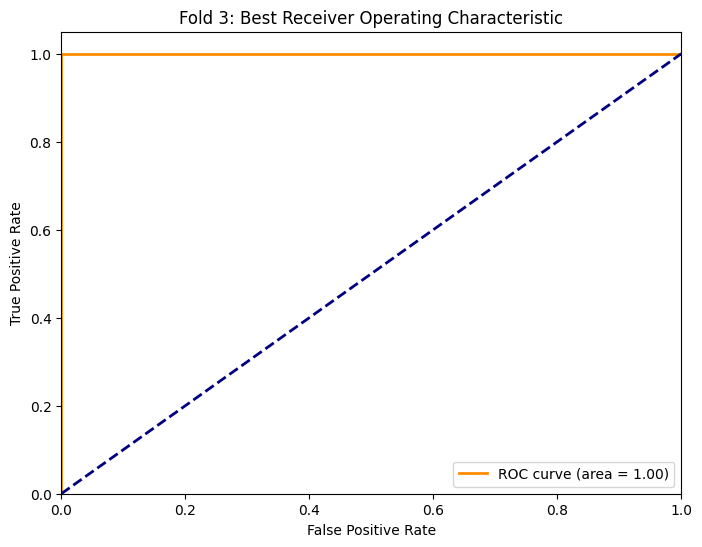

Fold 4/5
Best parameters for fold 4: {'dropout': 0.1, 'learning_rate': 0.001, 'weight_decay': 0.0001}
Retraining the model with best parameters...
Early stopping at epoch 51


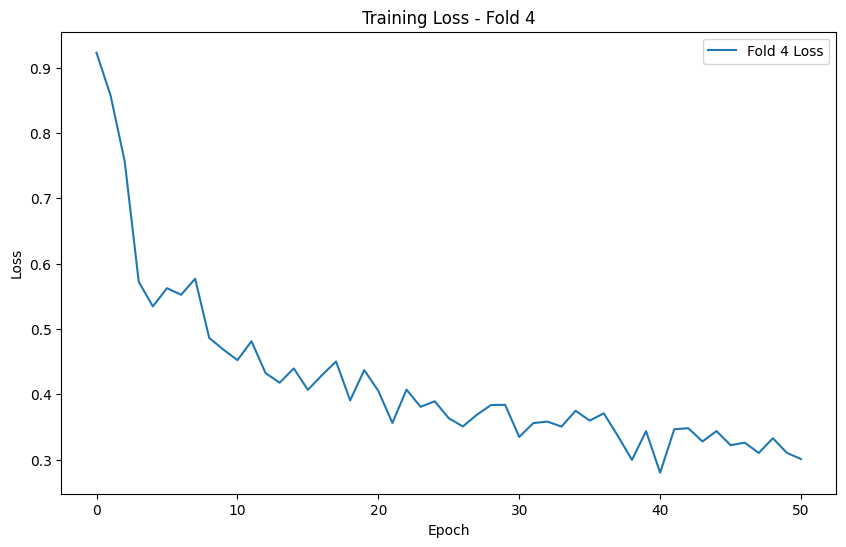

Fold 4 - Accuracy: 0.9828, Precision: 0.9857, Recall: 0.9792, F1 Score: 0.9821, ROC AUC: 1.0000


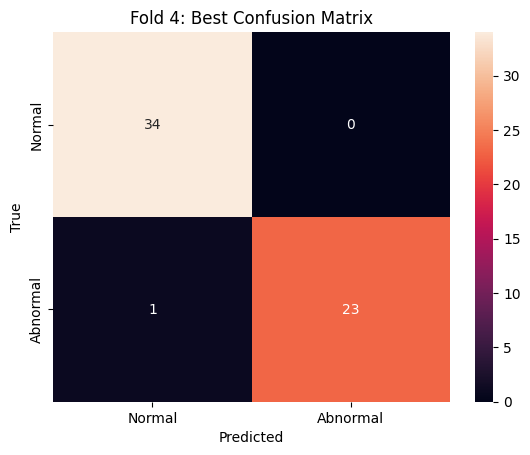

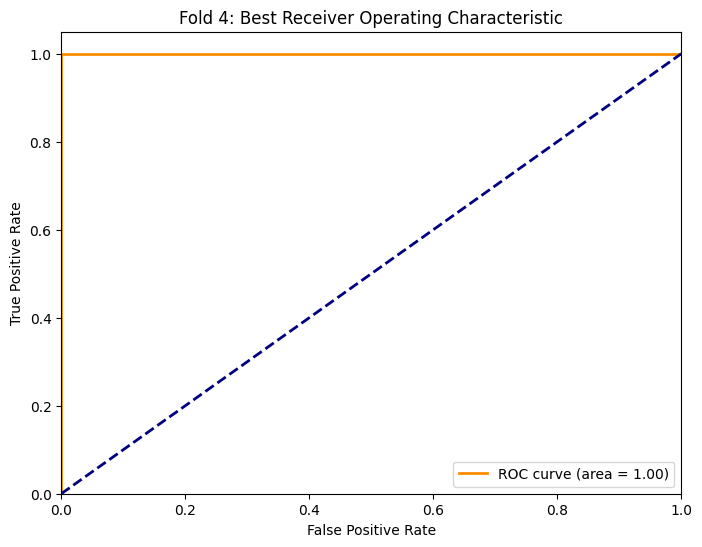

Fold 5/5
Best parameters for fold 5: {'dropout': 0.1, 'learning_rate': 0.002, 'weight_decay': 1e-06}
Retraining the model with best parameters...
Early stopping at epoch 62


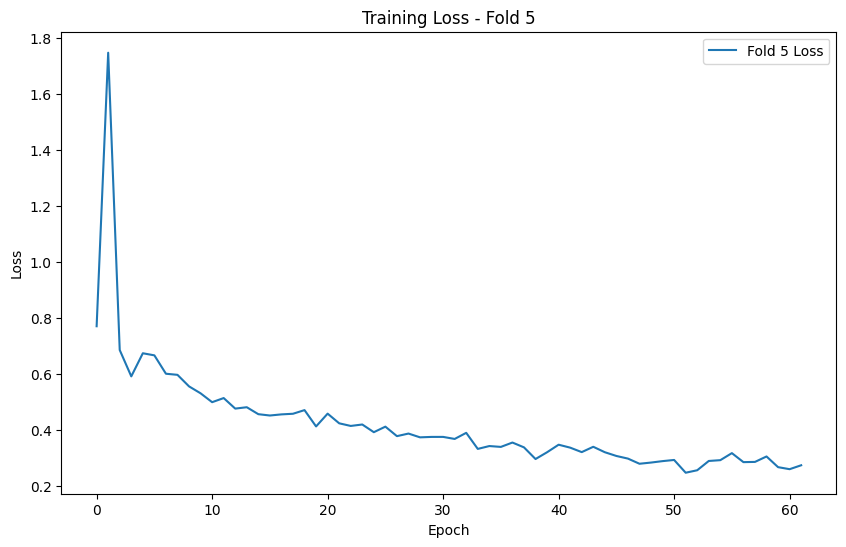

Fold 5 - Accuracy: 0.9310, Precision: 0.9574, Recall: 0.8667, F1 Score: 0.9009, ROC AUC: 1.0000


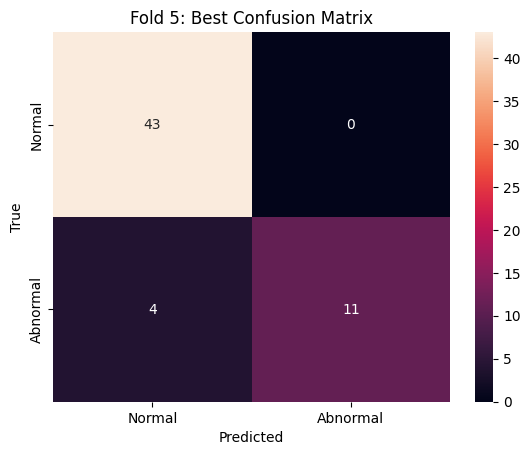

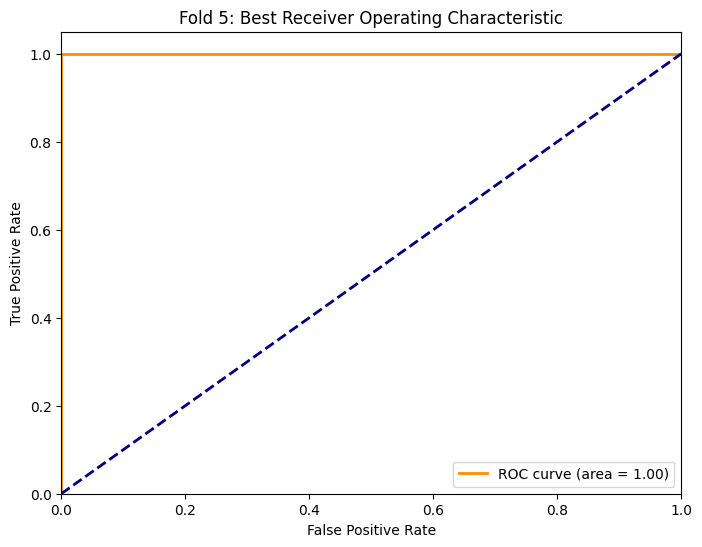

In [4]:
# Define the number of folds for cross-validation
k_folds = 5
kf = KFold(n_splits = k_folds, shuffle = True, random_state = 42)

# Initialize metrics to collect results from each fold
accuracies = []
precisions = []
recalls = []
f1s = []
roc_aucs = []

param_grid = {
    'learning_rate': [0.002, 0.001, 0.0005],
    'weight_decay': [1e-4, 1e-5, 1e-6],
    'dropout': [0.5, 0.3, 0.1]
}

# Perform K-Fold Cross-Validation
for fold, (train_index, test_index) in enumerate(kf.split(node_features)):
    print(f'Fold {fold + 1}/{k_folds}')

    # Create lists to hold the results for plotting
    Count = 1
    loss_values_folds = []
    confusion_matrices = []
    roc_curves = []
    
    # Split data
    X_train, X_test = node_features[train_index], node_features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    # Create Data objects for training and testing sets
    train_data = create_graph_data(X_train, y_train)
    test_data = create_graph_data(X_test, y_test)
    
    # Create DataLoader instances
    train_loader = GeometricDataLoader([train_data], batch_size = 1, shuffle = True)
    test_loader = GeometricDataLoader([test_data], batch_size = 1, shuffle = False)

    best_params = None
    best_fold_metrics = None
    best_fold_loss = float('inf')


    # Iterate over parameter combinations
    for params in ParameterGrid(param_grid):
        learning_rate = params['learning_rate']
        weight_decay = params['weight_decay']
        dropout = params['dropout']
    
        # Initialize the model with the current set of parameters
        model = AdvancedGNNModel(num_node_features = 12, num_classes = 2, dropout = dropout)
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)
        criterion = torch.nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.9)
    
        # Train the model with early stopping
        epochs = 200
        early_stopping_patience = 10
        best_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(epochs):
            model.train()
            epoch_loss = 0
            for batch in train_loader:
                optimizer.zero_grad()
                out = model(batch)
                loss = criterion(out, batch.y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 2.0)
                optimizer.step()
                epoch_loss += loss.item()
            scheduler.step()
            
            # Early stopping
            epoch_loss /= len(train_loader)
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    Count = Count + 1
                    break

        # Save the best parameters for this fold
        if best_loss < best_fold_loss:
            best_fold_loss = best_loss
            best_params = params
    
    # After parameter tuning, retrain with the best parameters
    print(f"Best parameters for fold {fold+1}: {best_params}")
    # Retrain the model
    print("Retraining the model with best parameters...")

    # Initialize and retrain the model with the best parameters
    model = AdvancedGNNModel(num_node_features=12, num_classes=2, dropout=best_params['dropout'])
    optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])
    criterion = torch.nn.CrossEntropyLoss()

    # Train the model with early stopping
    epochs = 200
    early_stopping_patience = 10
    best_loss = float('inf')
    patience_counter = 0
    training_losses = []

    # Retrain on the fold's training data
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out, batch.y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        # Early stopping
        epoch_loss /= len(train_loader)
        training_losses.append(epoch_loss)
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch+1}")
                Count = Count + 1
                break
    
    # Plot Training Loss for Current Fold
    plt.figure(figsize=(10, 6))
    plt.plot(training_losses, label=f'Fold {fold + 1} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training Loss - Fold {fold + 1}')
    plt.legend()
    plt.show()

    # Evaluate the model
    model.eval()
    true_labels = []
    predictions = []
    probs = []
    
    with torch.no_grad():
        for batch in test_loader:
            out = model(batch)
            _, pred = out.max(dim = 1)
            predictions.extend(pred.tolist())
            true_labels.extend(batch.y.tolist())
            probs.extend(F.softmax(out, dim = 1)[:, 1].tolist())
        
    # Convert lists to numpy arrays for metric calculation
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)
    probs = np.array(probs)
    
    # Calculate metrics
    test_accuracy = accuracy_score(true_labels, predictions)
    test_precision = precision_score(true_labels, predictions, average = 'macro', zero_division = 0)
    test_recall = recall_score(true_labels, predictions, average = 'macro', zero_division = 0)
    test_f1 = f1_score(true_labels, predictions, average = 'macro', zero_division = 0)
    fpr, tpr, _ = roc_curve(true_labels, probs)
    test_roc_auc = auc(fpr, tpr)
    
    # Collect metrics for this fold
    accuracies.append(test_accuracy)
    precisions.append(test_precision)
    recalls.append(test_recall)
    f1s.append(test_f1)
    roc_aucs.append(test_roc_auc)

    print(f'Fold {fold + 1} - Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}, ROC AUC: {test_roc_auc:.4f}')

    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot = True, fmt = 'd', xticklabels = ['Normal', 'Abnormal'], yticklabels = ['Normal', 'Abnormal'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Fold {fold + 1}: Best Confusion Matrix')
    plt.show()

    # Plot ROC curve and calculate AUC
    best_fpr, best_tpr, _ = roc_curve(true_labels, probs)
    best_roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(best_fpr, best_tpr, color = 'darkorange', lw = 2, label = f'ROC curve (area = {best_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Fold {fold + 1}: Best Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

In [5]:
print(f'\nCross-Validation Results:')
# Print overall metrics
print(f'Overall Metrics:')
print(f'Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}')
print(f'Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}')
print(f'Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}')
print(f'F1 Score: {np.mean(f1s):.4f} ± {np.std(f1s):.4f}')
print(f'ROC AUC: {np.mean(roc_aucs):.4f} ± {np.std(roc_aucs):.4f}')


Cross-Validation Results:
Overall Metrics:
Accuracy: 0.9586 ± 0.0207
Precision: 0.9721 ± 0.0124
Recall: 0.9306 ± 0.0411
F1 Score: 0.9472 ± 0.0303
ROC AUC: 0.9952 ± 0.0084


Predicting Unknown Data

Accuracy: 0.9500
Precision: 0.9643
Recall: 0.9286
F1 Score: 0.9430
ROC AUC: 1.0000


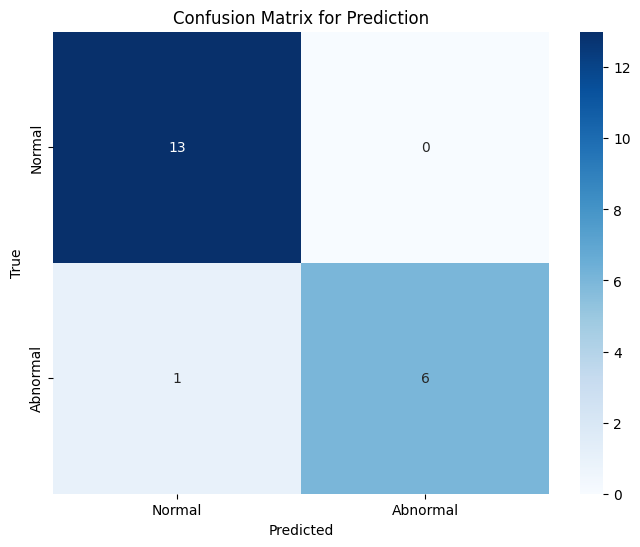

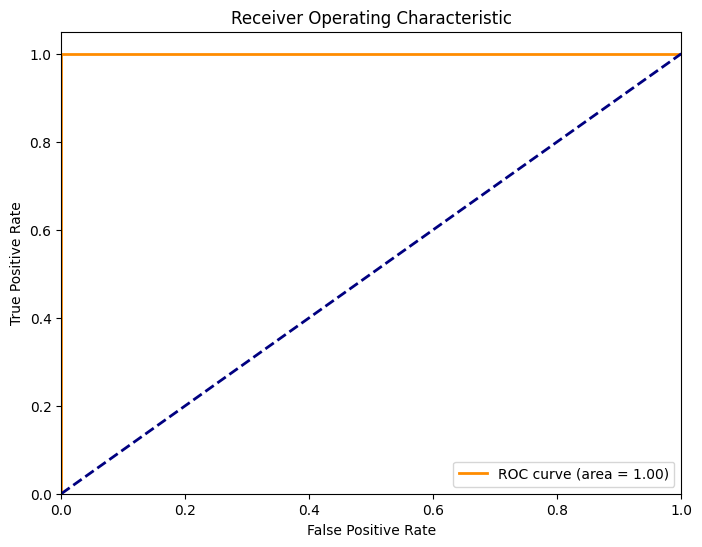

In [6]:
# Extract unknown evaluation data (first 13 rows and last 7 rows combined)
unknown_features = torch.tensor(
    np.vstack((InputData.iloc[:13, 1:13].values, InputData.iloc[-7:, 1:13].values)),
    dtype=torch.float
)
unknown_labels = torch.tensor(
    np.concatenate((InputData.iloc[:13, 14].values, InputData.iloc[-7:, 14].values)),
    dtype=torch.long
)

##unknown_features = torch.tensor(scaler.transform(unknown_features), dtype=torch.float)

# Create Data object for combined data
unknown_graph_data = create_graph_data(unknown_features, unknown_labels)

# Create DataLoader instance
unknown_data_loader = GeometricDataLoader([unknown_graph_data], batch_size=1, shuffle=False)

model.eval()

# Evaluate the model with combined data
unknown_predictions = []
unknown_probs = []

with torch.no_grad():
    for batch in unknown_data_loader:
        output = model(batch)
        _, pred = output.max(dim=1)
        unknown_predictions.extend(pred.tolist())
        unknown_probs.extend(torch.softmax(output, dim=1)[:, 1].tolist())

# Convert lists to numpy arrays for metric calculation
unknown_predictions = np.array(unknown_predictions)
unknown_probs = np.array(unknown_probs)

# Calculate metrics
evluation_accuracy = accuracy_score(unknown_labels, unknown_predictions)
evluation_precision = precision_score(unknown_labels, unknown_predictions, average='macro', zero_division=0)
evaluation_recall = recall_score(unknown_labels, unknown_predictions, average='macro', zero_division=0)
evaluation_f1 = f1_score(unknown_labels, unknown_predictions, average='macro', zero_division=0)
fpr, tpr, _ = roc_curve(unknown_labels, unknown_probs)
evaluation_roc_auc = auc(fpr, tpr)

print(f'Accuracy: {evluation_accuracy:.4f}')
print(f'Precision: {evluation_precision:.4f}')
print(f'Recall: {evaluation_recall:.4f}')
print(f'F1 Score: {evaluation_f1:.4f}')
print(f'ROC AUC: {evaluation_roc_auc:.4f}')

# Plot the confusion matrix
cm = confusion_matrix(unknown_labels, unknown_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Prediction')
plt.show()

# Plot ROC curve and calculate AUC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {evaluation_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

LIME Explanation

tensor(0)


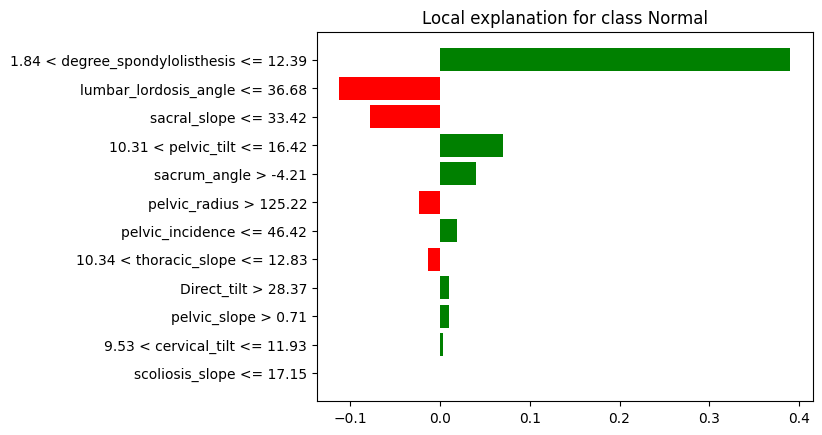

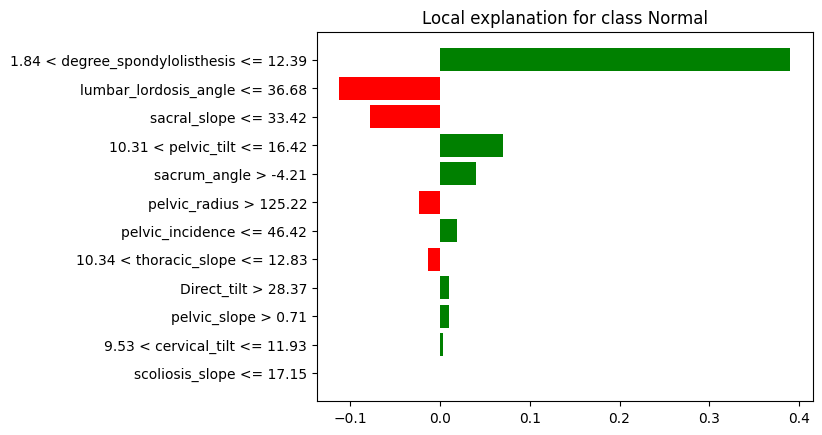

In [7]:
# Convert your torch model's prediction to work with LIME
def gnn_predict_proba(data):
    # data here is expected to be a numpy array for compatibility with LIME
    data_tensor = torch.tensor(data, dtype=torch.float)
    edge_index = torch.tensor([[0],[0]], dtype=torch.long)
    output = model(Data(x=data_tensor, edge_index=edge_index))
    # Converting log probabilities to probabilities for LIME
    proba = F.softmax(output, dim=1).detach().numpy()
    return proba

# Prepare the LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data = X_train.numpy(),  # Ensure the data is float
    feature_names = ["pelvic_incidence", "pelvic_tilt", "lumbar_lordosis_angle", "sacral_slope", "pelvic_radius",
                     "degree_spondylolisthesis", "pelvic_slope", "Direct_tilt", "thoracic_slope", "cervical_tilt",
                     "sacrum_angle", "scoliosis_slope"],
    class_names=['Abnormal', 'Normal'],
    mode='classification'
)

# Choose an instance to explain
i = np.random.randint(0, unknown_features.shape[0])
print(unknown_labels[i])
exp = explainer.explain_instance(unknown_features[i].numpy(), gnn_predict_proba, num_features = 12)

# Display the explanation in the notebook
exp.show_in_notebook(show_table=True, show_all=False)
exp.as_pyplot_figure()

Graph Data Visualization

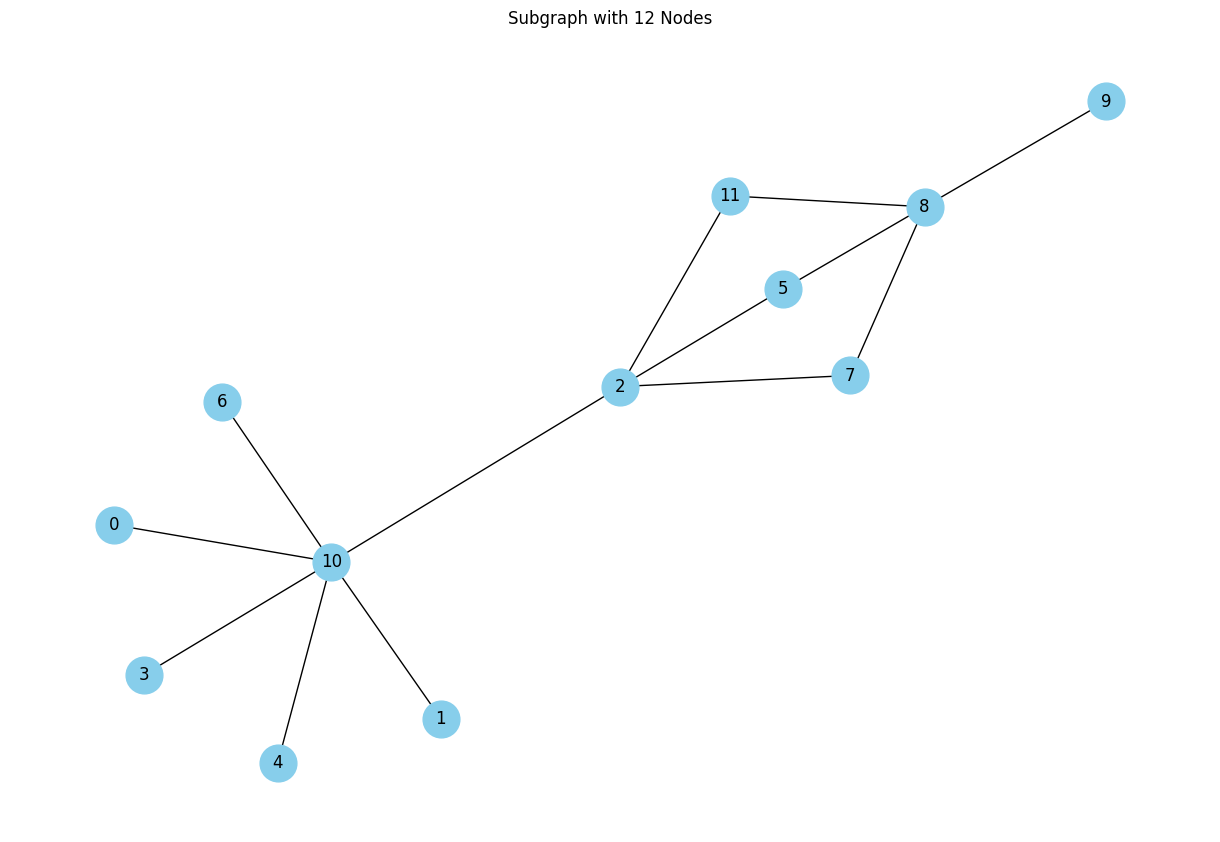

In [8]:
def visualize_graph(edge_index, num_nodes = 12):
    """
    Visualize a subgraph consisting of 'num_nodes' nodes and their corresponding edges.
    """
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    for i, j in edge_index.t().tolist():
        if i < num_nodes and j < num_nodes:
            G.add_edge(i, j)
    plt.figure(figsize=(12, 8))
    nx.draw(G, with_labels = True, node_color = 'skyblue', node_size = 700, edge_color = 'k')
    plt.title(f'Subgraph with {num_nodes} Nodes')
    plt.show()

# Visualize subgraph
visualize_graph(create_custom_edge_index(), num_nodes = 12)